Bidirectional Encoder Representations from Transformers are known as BERT. Towards the end of 2018, Google created and presented a brand-new language model. BERT is a multi-layer bidirectional Transformer encoder based on fine-tuning.

DistilBERT is a Transformer model based on the BERT architecture. To maximize training efficiency, DistilBERT strives to keep as much performance as possible while lowering the size of the BERT and speeding up the BERT. It is 40% smaller, 60% faster, and 97% functionally equivalent to the original BERT-base model.

Referances

1. https://www.marktechpost.com/2022/11/30/top-natural-language-processing-nlp-tools-platforms/
2. https://towardsdatascience.com/breaking-bert-down-430461f60efb

In [ ]:
!pip3 install tqdm
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 13.1 MB/s 
     |████████████████████████████████| 182 kB 56.5 MB/s 
     |████████████████████████████████| 7.6 MB 17.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF Version:  2.9.2
Eager mode:  True
GPU is available


In [ ]:
dir_path = "/content/gdrive/MyDrive/Colab Notebooks/Final_Project_Yashkumar_1138765/"

In [ ]:
# Loading dataset
data1=pd.read_excel(dir_path + "Data/Eng_Dataset.xlsx")
data2=pd.read_excel(dir_path + "Data/Guj_Dataset.xlsx")
data3=pd.read_excel(dir_path + "Data/Hin_Dataset.xlsx")
data4=pd.read_excel(dir_path + "Data/Mar_Dataset.xlsx")
data5=pd.read_excel(dir_path + "Data/Pun_Dataset.xlsx")

In [ ]:
# Concatanating the files data
dataset = pd.concat([
    data1[['comment_text', 'toxic']],
    data2[['comment_text', 'toxic']],
    data3[['comment_text', 'toxic']],
    data4[['comment_text', 'toxic']],
    data5[['comment_text', 'toxic']]
])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14995 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   comment_text  14995 non-null  object 
 1   toxic         14995 non-null  float64
dtypes: float64(1), object(1)
memory usage: 351.4+ KB


In [ ]:
# split the data in train, validation and test set
text = dataset['comment_text'].values
toxic = dataset['toxic'].values

x_train = text[:10000]
x_val = text [10000:13000]
x_test = text[13000:]

y_train = toxic[:10000]
y_val = toxic [10000:13000]
y_test = toxic[13000:]

In [ ]:
# Loading Distil-Bert tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

This function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad/truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from 
[PAD] tokens.

In [ ]:
def create_distilbert_input_features(tokenizer, texts, max_seq_length):
    
    input_ids, input_masks= [], []

    for text in tqdm.tqdm(texts):

        # Tokeniz the text
        tokens = tokenizer.tokenize(text)

        # Truncate tokens with extra length
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]

        # Appand [CLS] at start and [SEP] at end of sequence
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to ids
        ids = tokenizer.convert_tokens_to_ids(tokens)

        # Create mask list of '1' same as sequence length  
        masks = [1] * len(ids)

        # Pad sequences and make all same size
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        input_ids.append(ids)
        input_masks.append(masks)

    return np.array([input_ids, input_masks])

In [ ]:
max_seq_len = 250

inp_id = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

# Adding pre-trained model onto Sequential Neural Network for fine tuning
hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased',  num_labels=2)(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
dense3 = tf.keras.layers.Dense(64, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.25)(dense3)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

model = tf.keras.Model(inputs=inputs, outputs=output)

Downloading:   0%|          | 0.00/911M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Compile model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 250)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  134734080  ['bert_input_ids[0][0]',         
 BertModel)                     ast_hidden_state=(N               'bert_input_masks[0][0]']       
                                one, 250, 768),                                                   
                                 hidden_states=None                                           

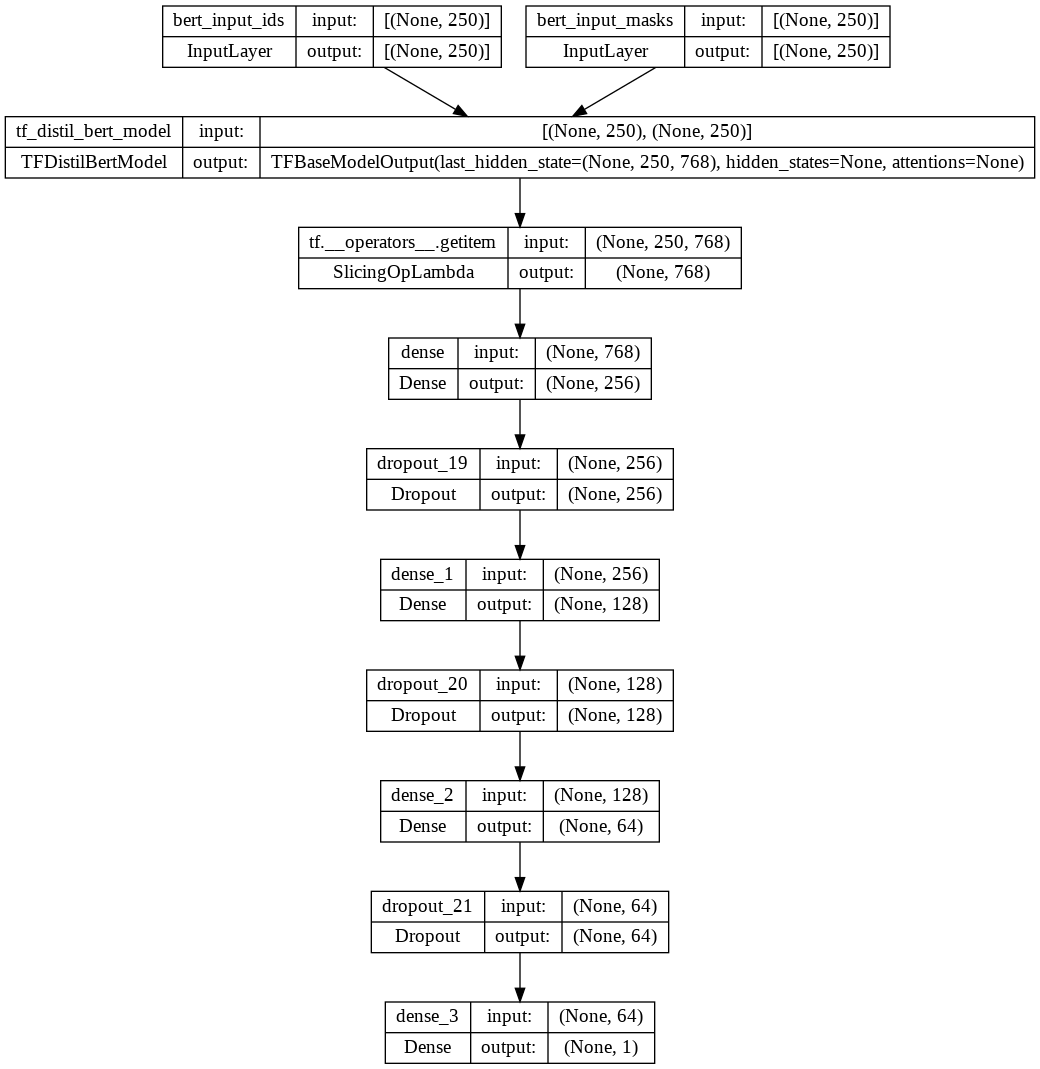

In [ ]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [ ]:
# Converting train data into input ids and attention mask
train_features_ids, train_features_masks = create_distilbert_input_features(tokenizer, x_train, 
                                                                       max_seq_length=max_seq_len)

# Converting validation data into input ids and attention mask
val_features_ids, val_features_masks = create_distilbert_input_features(tokenizer, x_val, 
                                                                       max_seq_length=max_seq_len)

print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

100%|██████████| 3000/3000 [00:05<00:00, 510.53it/s]


Train Features: (10000, 250) (10000, 250)
Val Features: (3000, 250) (3000, 250)


In [ ]:
print(train_features_ids)

[[  101 27746 31609 ...     0     0     0]
 [  101   141 56237 ...     0     0     0]
 [  101 35936 10817 ...     0     0     0]
 ...
 [  101 44551 18869 ...     0     0     0]
 [  101   885 18321 ... 15070 50051   102]
 [  101   898 13841 ... 77285   117   102]]


In [ ]:
# Attention masks
print(train_features_masks)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [ ]:
# Callback EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit([train_features_ids, 
           train_features_masks], y_train, 
           validation_data=([val_features_ids, 
                            val_features_masks], y_val),
          epochs=5, 
          batch_size=5, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/5
2000/2000 [==============================] - 391s 193ms/step - loss: 0.4468 - accuracy: 0.7832 - val_loss: 3.4007 - val_accuracy: 0.5407
Epoch 2/5
2000/2000 [==============================] - 383s 192ms/step - loss: 0.2656 - accuracy: 0.8933 - val_loss: 4.3603 - val_accuracy: 0.5383
Epoch 3/5
2000/2000 [==============================] - 398s 199ms/step - loss: 0.1718 - accuracy: 0.9313 - val_loss: 3.7490 - val_accuracy: 0.5350
Epoch 4/5
2000/2000 [==============================] - 398s 199ms/step - loss: 0.1123 - accuracy: 0.9596 - val_loss: 4.4655 - val_accuracy: 0.5313
Epoch 4: early stopping


In [ ]:
# Converting test data into input ids and attention mask
test_features_ids, test_features_masks = create_distilbert_input_features(tokenizer, x_test, 
                                                                          max_seq_length=max_seq_len)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

100%|██████████| 1995/1995 [00:02<00:00, 689.56it/s]


Test Features: (1995, 250) (1995, 250)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making predications on validation data
predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks], verbose=0).ravel()]

# Calculating Accuracy Score and Classification report
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))

# Confusion matrix
cf_matrix =confusion_matrix(y_test, predictions)
pd.DataFrame(cf_matrix)

Accuracy: 56.94%
              precision    recall  f1-score   support

         0.0       0.36      0.93      0.52       495
         1.0       0.95      0.45      0.61      1500

    accuracy                           0.57      1995
   macro avg       0.66      0.69      0.56      1995
weighted avg       0.81      0.57      0.59      1995



,0,1
0,462,33
1,826,674


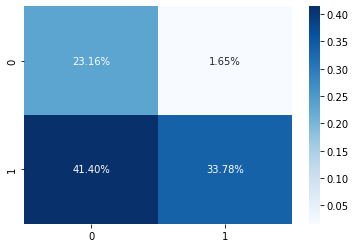

In [ ]:
# Plot Confusion matrix
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
path = dir_path + '/model/'

# Save weights in h5 file
model.save_weights(path + "my_Distil_Bert_model_Weights.h5", save_format='h5', overwrite=True)

In [ ]:
l_model = model

# Load Weights in the model
l_model.load_weights(path + "my_Distil_Bert_model_Weights.h5")
l_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 250)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  134734080  ['bert_input_ids[0][0]',         
 BertModel)                     ast_hidden_state=(N               'bert_input_masks[0][0]']       
                                one, 250, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
text= [" डी aww वह इस पृष्ठभूमि रंग से मेल खाता है मैं प्रतीत होता है कि धन्यवाद टॉक 21 51 जनवरी 11 2016 यूटीसी के साथ फंस गया है",
       "हाय मला वाटतं की तुम्ही सर्वात दुःखी व्यक्ती असाल ज्याच्याशी मी कधीही बोललो आहे एव्हर lgrainger199810",
       "ਤੁਹਾਨੂੰ ਇੱਕ ਬੇਵਕੂਫ ਹੋਣ ਲਈ ਟਰਾਊਟ ਕੀਤਾ ਗਿਆ ਹੈ",
       "You sir are my hero Any chance you remember what page that s on ",
       " મને લાગે છે કે હું ફ્રેડ ફેલ્પ્સની પાછળ ઉભો છું તે ક્યારેય તેની પાછળ કે સામે ઊભો રહેશે નહીં કારણ કે તે છે"]

# Converting text into ids and masks
test_features_ids, test_features_masks = create_distilbert_input_features(tokenizer, text, 
                                                                          max_seq_length=max_seq_len)

# Classifying the text
predictions = ["Toxic" if pr > 0.5 else "Non-Toxic" 
                   for pr in l_model.predict([test_features_ids, 
                                            test_features_masks], verbose=0).ravel()]

print("\n")
print(predictions)

100%|██████████| 5/5 [00:00<00:00, 1133.84it/s]




['Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Non-Toxic', 'Non-Toxic']


In [ ]:
# Loading Pre-trained DistilBert Sequnence classifier
distil_Model = transformers.TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased',  num_labels=2)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier', 'dropout_41', 'classifier']
You should probably TRAIN this model on a down-stream ta

In [ ]:
# Compile pre-trained classification model
distil_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])

# Callback EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
distil_Model.fit([train_features_ids, 
           train_features_masks], y_train, 
           validation_data=([val_features_ids, 
                            val_features_masks], y_val),
          epochs=5, 
          batch_size=5, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/5
2000/2000 [==============================] - 405s 200ms/step - loss: 0.5292 - accuracy: 0.4498 - val_loss: 6.0128 - val_accuracy: 0.5100
Epoch 2/5
2000/2000 [==============================] - 383s 191ms/step - loss: 0.4191 - accuracy: 0.5597 - val_loss: 6.6585 - val_accuracy: 0.3827
Epoch 3/5
2000/2000 [==============================] - 396s 198ms/step - loss: 0.3994 - accuracy: 0.6133 - val_loss: 7.0184 - val_accuracy: 0.1697
Epoch 4/5
2000/2000 [==============================] - 383s 191ms/step - loss: 0.4592 - accuracy: 0.5167 - val_loss: 6.7905 - val_accuracy: 0.4883
Epoch 4: early stopping


In [ ]:
# saving pre-trained model
path = dir_path + 'model/Distil'
distil_Model.save_pretrained(path, saved_model=True)

In [ ]:
# Loading the pre-trained model
distil_Model = transformers.TFDistilBertForSequenceClassification.from_pretrained(path,  id2label={0: 'Non-Toxic', 1: 'Toxic'})

Some layers from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/Final_Project_Yashkumar_1138765/model/Distil were not used when initializing TFDistilBertForSequenceClassification: ['dropout_41']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/Final_Project_Yashkumar_1138765/model/Distil and are newly initialized: ['dropout_61']
You should probably TRAIN this model on a down-st

In [ ]:
text = text= [" डी aww वह इस पृष्ठभूमि रंग से मेल खाता है मैं प्रतीत होता है कि धन्यवाद टॉक 21 51 जनवरी 11 2016 यूटीसी के साथ फंस गया है",
       "हाय मला वाटतं की तुम्ही सर्वात दुःखी व्यक्ती असाल ज्याच्याशी मी कधीही बोललो आहे एव्हर lgrainger199810",
       "ਤੁਹਾਨੂੰ ਇੱਕ ਬੇਵਕੂਫ ਹੋਣ ਲਈ ਟਰਾਊਟ ਕੀਤਾ ਗਿਆ ਹੈ",
       "You sir are my hero Any chance you remember what page that s on ",
       " મને લાગે છે કે હું ફ્રેડ ફેલ્પ્સની પાછળ ઉભો છું તે ક્યારેય તેની પાછળ કે સામે ઊભો રહેશે નહીં કારણ કે તે છે"]

# Classifying the text       
pipe = transformers.TextClassificationPipeline(model=distil_Model, tokenizer=tokenizer)
pipe(text)

[{'label': 'Non-Toxic', 'score': 0.5465138554573059},
 {'label': 'Non-Toxic', 'score': 0.5586320161819458},
 {'label': 'Non-Toxic', 'score': 0.5388920903205872},
 {'label': 'Non-Toxic', 'score': 0.5120198726654053},
 {'label': 'Non-Toxic', 'score': 0.5395165085792542}]

Referances:
1. https://www.kaggle.com/code/afi1289/nlp-with-disaster-tweets-cleaning-tf-idf-and-bert#7.-Fine-Tuning-BERT:
2. https://victordibia.com/blog/text-classification-hf-tf2/
3. https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras
4. https://github.com/keras-team/keras/issues/6447
5. https://github.com/dipanjanS/deep_transfer_learning_nlp_dhs2019/tree/master/notebooks
6. https://huggingface.co/
7. https://thecleverprogrammer.com/2020/12/06/resume-screening-with-python/#google_vignette
8. https://thecleverprogrammer.com/2020/12/07/sentiment-analysis-with-python/#google_vignette